## Imports

In [1]:
import torch
import torch.nn as nn
import scipy.stats as stats
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch import optim
import matplotlib.pyplot as plt

In [2]:
from icnnet import ICNNet
from mydataset import MyDataset
import toy_data_dataloader_gaussian

from gaussian_transport import compute_A, compute_w, guassian_transport

In [3]:
%load_ext autoreload
%autoreload 2

## Toy data


In [20]:
dataloader, locs, scales = toy_data_dataloader_gaussian.get_dataloader(N = 500, batch_size = 100, r = 250)

In [21]:
cov1 = np.eye(2)
cov2 = np.eye(2)
m1 = np.zeros(2)
m2 = np.ones(2)

A = compute_A(cov1, cov2)
w = compute_w(m1, m2, A)

In [22]:
x = list()
c = list()
y_transport = list()
for x_batch, c_batch, y_batch in dataloader:
    x.append(x_batch)
    c.append(c_batch)
    results = []
    for i in range(x_batch.shape[0]):
        for j in range(x_batch.shape[1]):
            result = guassian_transport(x_batch[i, j], A, w)
            results.append(result)
    y_transport.append(torch.stack(results).reshape((x_batch.shape[0], x_batch.shape[1],1)))

X = torch.cat(x, dim = 0)
C = torch.cat(c, dim = 0)
Y = torch.cat(y_transport, dim = 0).float()

gaussian_dataset = MyDataset(X, C, Y)
gaussian_dataloader = DataLoader(gaussian_dataset, batch_size=100, shuffle=True)

## __Training__

### PICNN training

In [23]:
epochs = 100

# Initialize the model
input_size = 2
output_size = 1

model = ICNNet(input_size = input_size, layer_sizes = [input_size, 64, 64, 64,output_size], context_layer_sizes=[input_size, 64, 64, 64,output_size])

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

for epoch in range(epochs):
    for x_batch, c_batch, y_batch in gaussian_dataloader:
        x_batch.requires_grad_(True)
        c_batch.requires_grad_(True)

        optimizer.zero_grad() # Zero the gradients
        
        output = model(x_batch, c_batch)  # Assuming context c is same as input x

        loss = criterion(output, y_batch) # Compute the loss
        loss.backward() # Backward pass

        optimizer.step() # Update the parameters
        for layers_k in model.layers_z:
            for param in layers_k.parameters():
                param.data.clamp_min_(0)

    # for name, parameter in model.named_parameters():
    #     if parameter.requires_grad and parameter.grad is not None:
    #         grad_norm = parameter.grad.norm().item()
    #         print(f"Gradient norm for {name}: {grad_norm}")
    
    print(f"Epoch {epoch+1}/{epochs} Loss: {loss.item()}")

Epoch 1/100 Loss: 6.606805801391602
Epoch 2/100 Loss: 5.50935697555542
Epoch 3/100 Loss: 4.243378162384033
Epoch 4/100 Loss: 2.90321946144104
Epoch 5/100 Loss: 2.980769634246826
Epoch 6/100 Loss: 2.3404464721679688
Epoch 7/100 Loss: 2.1061794757843018
Epoch 8/100 Loss: 1.7867587804794312
Epoch 9/100 Loss: 1.4961856603622437
Epoch 10/100 Loss: 1.2450453042984009
Epoch 11/100 Loss: 1.0004106760025024
Epoch 12/100 Loss: 0.8189041614532471
Epoch 13/100 Loss: 0.699837863445282
Epoch 14/100 Loss: 0.6301824450492859
Epoch 15/100 Loss: 0.5869362354278564
Epoch 16/100 Loss: 0.515818178653717
Epoch 17/100 Loss: 0.4798201024532318
Epoch 18/100 Loss: 0.43908289074897766
Epoch 19/100 Loss: 0.38369831442832947
Epoch 20/100 Loss: 0.3096574544906616
Epoch 21/100 Loss: 0.2456960529088974
Epoch 22/100 Loss: 0.20658376812934875
Epoch 23/100 Loss: 0.15210938453674316
Epoch 24/100 Loss: 0.1369023472070694
Epoch 25/100 Loss: 0.11576496809720993
Epoch 26/100 Loss: 0.1058838963508606
Epoch 27/100 Loss: 0.0995

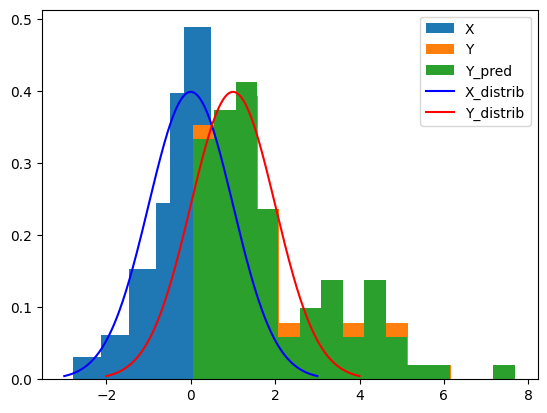

In [17]:
X = gaussian_dataloader.dataset.X
Y = gaussian_dataloader.dataset.Y
C = gaussian_dataloader.dataset.C


Y_pred  = model(X, C)[0, :, 0].detach().numpy()

plt.hist(X[0, :, 0],  bins=15, label = 'X', density = True)
plt.hist(Y[0, :, 0],  bins=15, label = 'Y', density = True)
plt.hist(Y_pred, bins=15, label = 'Y_pred', density = True)
#plt.axvline(x = Y_pred, color = 'black', label = 'Y_pred')
plt.plot(np.linspace(-3, 3, 300), stats.norm.pdf(np.linspace(-3, 3, 300), loc=0, scale=1), label = 'X_distrib', color = 'blue')
plt.plot(np.linspace(-3*scales[0, 0] + locs[0, 0], 3*scales[0, 0] + locs[0, 0], 300), stats.norm.pdf(np.linspace(-3*scales[0, 0] + locs[0, 0], 3*scales[0, 0] + locs[0, 0], 300), loc=locs[0, 0], scale=scales[0, 0]), label = 'Y_distrib', color = 'red')

plt.legend()

plt.show()

In [ ]:
#Calcul de la dérivée du PICNN

test = 17
x_i = X[test, :, :]
y_i = Y[test, :, :]
c_i = C[test, :, :]


y_i.requires_grad_(True)
x_i.requires_grad_(True)
#c_i.requires_grad_(True)    

output_f = model(x_i, c_i)


grad_f = torch.autograd.grad(outputs=output_f, inputs=x_i, grad_outputs=torch.ones_like(output_f), create_graph=True)[0]

plt.hist(X[test, :, 0],  bins=15, label = 'X', density = True)
plt.hist(Y[test, :, 0],  bins=15, label = 'Y', density = True)
plt.hist(grad_f[:, 0].detach().numpy(),  bins=15, label = 'grad_f', density = True, alpha = 0.5)
# plt.hist(X_pred,  bins=15, label = 'X_pred', density = True, alpha = 0.5)
plt.plot(np.linspace(-3, 3, 300), stats.norm.pdf(np.linspace(-3, 3, 300), loc=0, scale=1), label = 'X_distrib', color = 'blue')
plt.plot(np.linspace(-3*scales[test, 0] + locs[test, 0], 3*scales[test, 0] + locs[test, 0], 300), stats.norm.pdf(np.linspace(-3*scales[test, 0] + locs[test, 0], 3*scales[test, 0] + locs[test, 0], 300), loc=locs[test, 0], scale=scales[test, 0]), label = 'Y_distrib', color = 'red')

plt.legend()

plt.show()

### PICNN training

## __Makkuva__

In [ ]:
epochs = 100
train_freq_g = 3

# Initialize the model
input_size = 2
output_size = 1

ICNNf = ICNNet(input_size = 2, layer_sizes = [input_size, 16, 16, 16,output_size], context_layer_sizes=[input_size, 16, 16, 16,output_size])
ICNNg = ICNNet(input_size = 2, layer_sizes = [input_size, 16, 16, 16,output_size], context_layer_sizes=[input_size, 16, 16, 16,output_size])

# ICNNf = ICNNet(input_size = 2, layer_sizes = [input_size, 2, 2, 2,2], context_layer_sizes=[2,2, 2, 2,2])
# ICNNg = ICNNet(input_size = 2, layer_sizes = [output_size, 2, 2, 2,2], context_layer_sizes=[2,2, 2, 2,2]) 

print(f'The model has {count_parameters(ICNNf)} parameters')
# Define the loss function and the optimizer
optimizer_f = optim.Adam(ICNNf.parameters(), lr = 0.1)
optimizer_g = optim.Adam(ICNNg.parameters(), lr = 0.1)

for epoch in range(epochs):
    for freq in range(train_freq_g) :
        for x, c, y in dataloader:
            # Optimizing ICNNg
            optimizer_f.zero_grad() # Zero the gradients
            optimizer_g.zero_grad() # Zero the gradients

            x.requires_grad_(True)
            y.requires_grad_(True)
            c.requires_grad_(True)

            output_g = ICNNg(y, c)
            grad_g = torch.autograd.grad(output_g, y, grad_outputs=torch.ones_like(output_g), create_graph=True)[0]

            loss_g = ICNNf(grad_g, c) - torch.sum(y * grad_g, dim=-1, keepdim=True)
            loss_g = loss_g.mean(dim=(1, 2)).mean()

            #print('min f(grad_g, c)', ICNNf(grad_g, c)[0][0])
            #print('max f(grad_g, c)', torch.sum(y * grad_g, dim=-1, keepdim=True)[0][0])

            loss_g.backward() # Backward pass
            optimizer_g.step() # Update the parameters

            for layers_k in ICNNg.layers_z:
                for param in layers_k.parameters():
                    param.data.clamp_min_(0)
                    
            # for name, parameter in ICNNg.named_parameters():
            #     if parameter.requires_grad and parameter.grad is not None:
            #         grad_norm = parameter.grad.norm().item()
            #         print(f"Gradient norm for {name}: {grad_norm}")
                    
            #print(f"training g {freq+1}/{train_freq_g} loss_g: {loss_g.item()}")

    for x, c, y in dataloader:
        optimizer_f.zero_grad() # Zero the gradients
        optimizer_g.zero_grad()

        x.requires_grad_(True)
        y.requires_grad_(True)
        c.requires_grad_(True)
    
        output_g = ICNNg(y, c)
        grad_g = torch.autograd.grad(outputs=output_g, inputs=y, grad_outputs=torch.ones_like(output_g), create_graph=True)[0]

        #print('ICNNf(grad_g, c)', ICNNf(grad_g, c))

        loss_f = ICNNf(x, c) - ICNNf(grad_g, c)
        #loss_f =  torch.mean(loss_f)
        loss_f =   torch.mean(loss_f) #page 24, f is updated by fixing g and maximizing (15) with a single iteration

        #print('max f(grad_g, c)', ICNNf(grad_g, c)[0][0])

        loss_f.backward() # Backward pass
        optimizer_f.step()
        
        for layers_k in ICNNf.layers_z:
                for param in layers_k.parameters():
                    param.data.clamp_min_(0)

        # for name, parameter in ICNNf.named_parameters():
        #     if parameter.requires_grad and parameter.grad is not None:
        #         grad_norm = parameter.grad.norm().item()
        #         print(f"Gradient norm for {name}: {grad_norm}")
        
    print(f"Epoch {epoch+1}/{epochs} loss_g: {loss_g.item()}, loss_f: {loss_f.item()}")

The model has 3002 parameters
Epoch 1/100 loss_g: -2488023552.0, loss_f: -4369462591488.0
Epoch 2/100 loss_g: 4931285.0, loss_f: -161006976.0
Epoch 3/100 loss_g: 681300.875, loss_f: 4841582.0
Epoch 4/100 loss_g: 2880590.0, loss_f: 7925768.0
Epoch 5/100 loss_g: 4001221.0, loss_f: 11934491.0
Epoch 6/100 loss_g: 2845445.5, loss_f: 13297341.0
Epoch 7/100 loss_g: 655609.375, loss_f: 7892245.5
Epoch 8/100 loss_g: 368761.84375, loss_f: 3885242.75
Epoch 9/100 loss_g: 256516.8125, loss_f: 2264292.25
Epoch 10/100 loss_g: 167651.3125, loss_f: 1695404.0
Epoch 11/100 loss_g: 82282.3515625, loss_f: 1189054.0
Epoch 12/100 loss_g: 48036.8515625, loss_f: 785876.25
Epoch 13/100 loss_g: 31350.39453125, loss_f: 567798.0
Epoch 14/100 loss_g: 34863.1640625, loss_f: 343002.71875
Epoch 15/100 loss_g: 37381.7265625, loss_f: 237045.5
Epoch 16/100 loss_g: 39085.890625, loss_f: 254346.0625
Epoch 17/100 loss_g: 39790.7265625, loss_f: 180913.625
Epoch 18/100 loss_g: 39586.59375, loss_f: 167072.078125
Epoch 19/100 l

In [ ]:
filename_pth_f = 'ICNNf_64_4_uniform_50epochs.pth'
filename_pth_g = 'ICNNf_64_4_uniform_50epochs.pth'

torch.save(ICNNf.state_dict(), filename_pth_f)
torch.save(ICNNg.state_dict(), filename_pth_g)

In [ ]:
ICNNf = ICNNet(input_size = 2, layer_sizes = [input_size,64,64,64,64,output_size], context_layer_sizes=[input_size,64,64,64,64,output_size])
ICNNf.load_state_dict(torch.load(filename_pth_f))

ICNNg = ICNNet(input_size = 2, layer_sizes = [output_size,64,64,64,64,input_size], context_layer_sizes=[output_size,64,64,64,64,input_size])
ICNNg.load_state_dict(torch.load(filename_pth_g))

<All keys matched successfully>

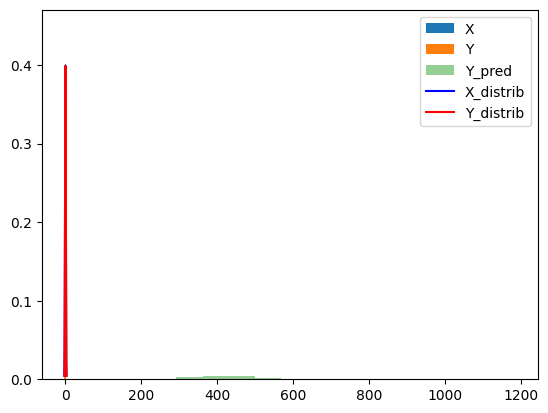

In [ ]:
X = dataloader.dataset.X
Y = dataloader.dataset.Y
C = dataloader.dataset.C

test = 21

Y_pred = ICNNf(X, C)[test, :, 0].detach().numpy()
X_pred = ICNNg(Y, C)[test, :, 0].detach().numpy()


plt.hist(X[test, :, 0],  bins=15, label = 'X', density = True)
plt.hist(Y[test, :, 0],  bins=15, label = 'Y', density = True)
plt.hist(Y_pred,  bins=15, label = 'Y_pred', density = True, alpha = 0.5)
# plt.hist(X_pred,  bins=15, label = 'X_pred', density = True, alpha = 0.5)
plt.plot(np.linspace(-3, 3, 300), stats.norm.pdf(np.linspace(-3, 3, 300), loc=0, scale=1), label = 'X_distrib', color = 'blue')
plt.plot(np.linspace(-3*scales[test, 0] + locs[test, 0], 3*scales[test, 0] + locs[test, 0], 300), stats.norm.pdf(np.linspace(-3*scales[test, 0] + locs[test, 0], 3*scales[test, 0] + locs[test, 0], 300), loc=locs[test, 0], scale=scales[test, 0]), label = 'Y_distrib', color = 'red')

plt.legend()
plt.show()

tensor([[ 3.1966e-01, -1.1600e+00],
        [ 6.2075e-01,  7.6491e-01],
        [ 8.6549e-01,  1.3013e+00],
        [ 1.8802e-01,  1.5525e-01],
        [ 6.4383e-02, -2.7334e-01],
        [-1.0527e+00, -3.2778e-01],
        [ 6.3946e-02,  5.4852e-02],
        [ 1.0853e+00, -9.8292e-01],
        [ 9.8859e-01,  3.2222e-01],
        [ 1.6072e+00,  8.6403e-01],
        [-2.8149e-01, -9.8020e-01],
        [-7.5473e-01, -1.2996e-01],
        [-1.2634e+00,  8.3242e-01],
        [ 3.8428e-01, -5.2387e-01],
        [ 1.1598e+00,  6.9157e-01],
        [-1.0038e+00, -1.0497e+00],
        [-6.7453e-01,  4.4290e-01],
        [-1.9501e-01, -8.4989e-01],
        [-1.2357e+00,  5.4657e-01],
        [ 7.0410e-02, -1.1823e+00],
        [ 7.2613e-01, -9.9976e-01],
        [-1.1724e+00, -1.9262e-01],
        [-6.2877e-01, -4.8849e-02],
        [-2.4789e-01, -2.8809e-03],
        [-3.2578e-01,  8.6832e-01],
        [ 1.0944e+00, -1.8215e+00],
        [ 7.4986e-01,  7.3351e-01],
        [ 1.7440e+00, -9.494

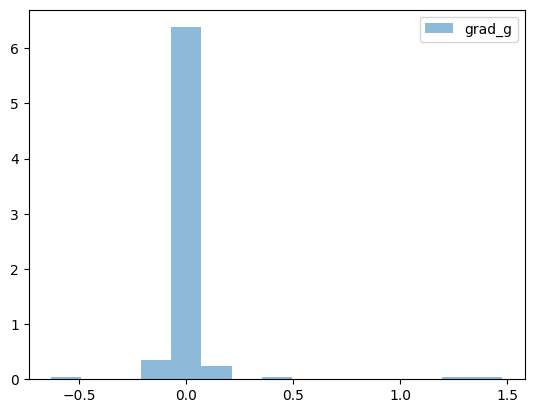

In [ ]:
#Calcul de la dérivée du PICNN

test =  50
x_i = X[test, :, :]
c_i = C[test, :, :]


x_i.requires_grad_(True)
#c_i.requires_grad_(True)    

print(x_i)
output_g = ICNNg(x_i, c_i)
grad_g = torch.autograd.grad(outputs=output_g, inputs=x_i, grad_outputs=torch.ones_like(output_g), create_graph=True)[0]
print(grad_g)

#plt.hist(X[test, :, 0],  bins=15, label = 'X', density = True)
#plt.hist(Y[test, :, 0],  bins=15, label = 'Y', density = True)
plt.hist(grad_g[:, 0].detach().numpy(),  bins=15, label = 'grad_g', density = True, alpha = 0.5)
plt.legend()

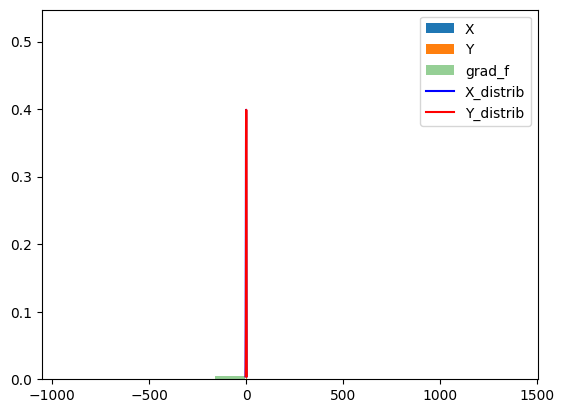

In [ ]:
#Calcul de la dérivée du PICNN

test =  27
x_i = X[test, :, :]
c_i = C[test, :, :]


x_i.requires_grad_(True)
#c_i.requires_grad_(True)    

output_f = ICNNf(x_i, c_i)

grad_f = torch.autograd.grad(outputs=output_f, inputs=x_i, grad_outputs=torch.ones_like(output_f), create_graph=True)[0]

plt.hist(X[test, :, 0],  bins=15, label = 'X', density = True)
plt.hist(Y[test, :, 0],  bins=15, label = 'Y', density = True)
plt.hist(grad_f[:, 0].detach().numpy(),  bins=15, label = 'grad_f', density = True, alpha = 0.5)
# plt.hist(X_pred,  bins=15, label = 'X_pred', density = True, alpha = 0.5)
plt.plot(np.linspace(-3, 3, 300), stats.norm.pdf(np.linspace(-3, 3, 300), loc=0, scale=1), label = 'X_distrib', color = 'blue')
plt.plot(np.linspace(-3*scales[test, 0] + locs[test, 0], 3*scales[test, 0] + locs[test, 0], 300), stats.norm.pdf(np.linspace(-3*scales[test, 0] + locs[test, 0], 3*scales[test, 0] + locs[test, 0], 300), loc=locs[test, 0], scale=scales[test, 0]), label = 'Y_distrib', color = 'red')

plt.legend()

plt.show()

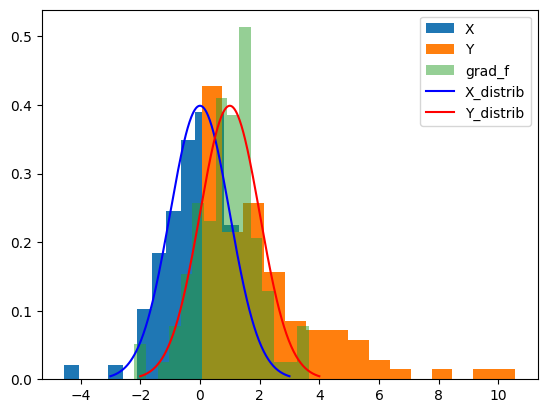

In [19]:
#Calcul de la dérivée du PICNN

test = 17
x_i = X[test, :, :]
y_i = Y[test, :, :]
c_i = C[test, :, :]


y_i.requires_grad_(True)
x_i.requires_grad_(True)
#c_i.requires_grad_(True)    

output_f = model(x_i, c_i)


grad_f = torch.autograd.grad(outputs=output_f, inputs=x_i, grad_outputs=torch.ones_like(output_f), create_graph=True)[0]

plt.hist(X[test, :, 0],  bins=15, label = 'X', density = True)
plt.hist(Y[test, :, 0],  bins=15, label = 'Y', density = True)
plt.hist(grad_f[:, 0].detach().numpy(),  bins=15, label = 'grad_f', density = True, alpha = 0.5)
# plt.hist(X_pred,  bins=15, label = 'X_pred', density = True, alpha = 0.5)
plt.plot(np.linspace(-3, 3, 300), stats.norm.pdf(np.linspace(-3, 3, 300), loc=0, scale=1), label = 'X_distrib', color = 'blue')
plt.plot(np.linspace(-3*scales[test, 0] + locs[test, 0], 3*scales[test, 0] + locs[test, 0], 300), stats.norm.pdf(np.linspace(-3*scales[test, 0] + locs[test, 0], 3*scales[test, 0] + locs[test, 0], 300), loc=locs[test, 0], scale=scales[test, 0]), label = 'Y_distrib', color = 'red')

plt.legend()

plt.show()